# Speech Command Classification with Torchaudio&CNN Model

## Model Introduction
This model is set up by CNN to train and test the dataset.

## Install necessary libraries and import

In [34]:
!pip install torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable


In [35]:
!pip install datasets[audio]

Defaulting to user installation because normal site-packages is not writeable


In [36]:
!pip install transformers[torch]

Defaulting to user installation because normal site-packages is not writeable


In [37]:
!pip install soundfile

Defaulting to user installation because normal site-packages is not writeable


In [38]:
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
import sys
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm

Let’s check if a CUDA GPU is available and select our device. Running the network on a GPU will greatly decrease the training/testing runtime.

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Load the Dataset
We used torchaudio to download and process the dataset. Then we will use the SpeechCommands dataset, which contains 35 different passwords. All audio files in this dataset are approximately 1 second long (16,000 time frames).

In [40]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

Inspect and visualize the data

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


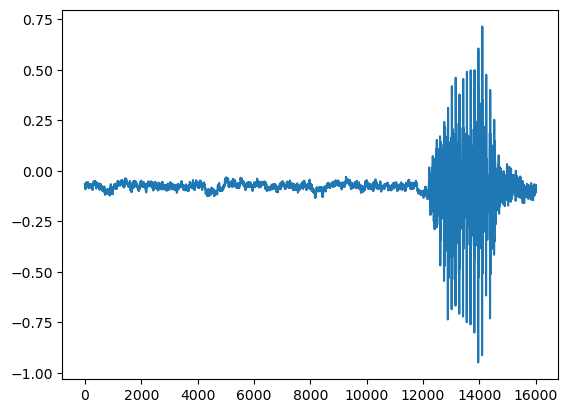

In [41]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

We can find the list of labels available in the dataset.

In [42]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [43]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

The last file is someone saying “zero”.




In [44]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

## Formatting the Data

In [45]:
new_sample_rate = 16000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.




In [49]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [50]:
import torch
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Define the Network
We will utilize a convolutional neural network (CNN) to process raw audio data. While more advanced transformations are commonly applied to audio data, CNNs are capable of effectively handling raw inputs. For this project, the architecture is specifically tailored, based on modifications to the M5 and M11 models in [this paper](https://arxiv.org/pdf/1610.00087.pdf). to process audio sampled at 16kHz.

In [56]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


M11

In [ ]:
class M11(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, n_channel * 2, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(n_channel * 2)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(n_channel * 2, n_channel * 4, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(n_channel * 4)
        self.pool4 = nn.MaxPool1d(4)
        self.conv5 = nn.Conv1d(n_channel * 4, n_channel * 4, kernel_size=3)
        self.bn5 = nn.BatchNorm1d(n_channel * 4)
        self.gap = nn.AdaptiveAvgPool1d(1)

        self.fc = nn.Linear(n_channel * 4, n_output)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = self.gap(F.relu(self.bn5(self.conv5(x))))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

new_model = M11(n_input=transformed.shape[0], n_output=len(labels))
new_model.to(device)
print(new_model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n = count_parameters(new_model)
print("Number of parameters: %s" % n)

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.

In [55]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

## Training and Testing the Network

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps.




In [ ]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset.



In [ ]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network.



In [ ]:
log_interval = 20
n_epoch = 5

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

In [31]:
log_interval = 20
n_epoch = 4

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

  0%|                                                               | 0.0026666666666666666/4 [00:02<51:02, 766.06s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 0.674281


  1%|▉                                                                | 0.05599999999999999/4 [00:32<42:16, 643.20s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 0.529098


  3%|█▊                                                               | 0.10933333333333328/4 [01:07<43:27, 670.14s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 0.613912


  4%|██▋                                                              | 0.16266666666666676/4 [01:41<40:24, 631.85s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 0.637412


  5%|███▌                                                             | 0.21600000000000033/4 [02:14<38:35, 611.98s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 0.683953


  7%|████▍                                                             | 0.2693333333333337/4 [02:45<36:32, 587.65s/it]

Train Epoch: 1 [25600/84843 (30%)]	Loss: 0.547760


  8%|█████▎                                                            | 0.3226666666666667/4 [03:16<37:20, 609.32s/it]

Train Epoch: 1 [30720/84843 (36%)]	Loss: 0.601164


  9%|██████▏                                                           | 0.3759999999999997/4 [03:48<35:42, 591.24s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 0.623074


 11%|██████▉                                                          | 0.42933333333333273/4 [04:19<34:47, 584.60s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 0.647064


 12%|███████▊                                                         | 0.48266666666666574/4 [04:50<34:39, 591.21s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 0.751582


 13%|████████▊                                                         | 0.5359999999999995/4 [05:20<28:43, 497.69s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 0.555679


 15%|█████████▋                                                        | 0.5893333333333336/4 [05:46<28:17, 497.68s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 0.517582


 16%|██████████▌                                                       | 0.6426666666666677/4 [06:12<27:54, 498.76s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 0.631965


 17%|███████████▍                                                      | 0.6960000000000018/4 [06:38<27:21, 496.94s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 0.719437


 19%|████████████▌                                                      | 0.749333333333336/4 [07:03<26:37, 491.56s/it]

Train Epoch: 1 [71680/84843 (84%)]	Loss: 0.698272


 20%|█████████████▏                                                    | 0.8026666666666701/4 [07:29<26:07, 490.36s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 0.579594


 21%|██████████████                                                    | 0.8560000000000042/4 [07:55<25:17, 482.82s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 0.475852


 25%|████████████████▌                                                 | 1.0000000000000062/4 [09:03<23:35, 471.97s/it]


Test Epoch: 1	Accuracy: 8786/11005 (80%)



 25%|████████████████▌                                                 | 1.0026666666666728/4 [09:04<24:00, 480.57s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: 0.545465


 26%|█████████████████▍                                                | 1.0560000000000047/4 [09:29<23:30, 479.11s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 0.627352


 28%|██████████████████▎                                               | 1.1093333333333366/4 [09:56<26:00, 539.89s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 0.567699


 29%|███████████████████▏                                              | 1.1626666666666685/4 [10:23<22:53, 483.98s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 0.560697


 30%|████████████████████                                              | 1.2160000000000004/4 [10:48<22:51, 492.71s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 0.591092


 32%|████████████████████▉                                             | 1.2693333333333323/4 [11:15<22:16, 489.38s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 0.525617


 33%|█████████████████████▊                                            | 1.3226666666666642/4 [11:40<21:53, 490.45s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.545204


 34%|██████████████████████▋                                           | 1.3759999999999961/4 [12:06<21:28, 491.01s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.443154


 36%|███████████████████████▉                                           | 1.429333333333328/4 [12:31<22:18, 520.86s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.425958


 37%|█████████████████████████▏                                          | 1.48266666666666/4 [12:57<20:40, 492.66s/it]

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.523371


 38%|█████████████████████████▎                                        | 1.5359999999999918/4 [13:23<19:47, 481.79s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.595325


 40%|██████████████████████████▏                                       | 1.5893333333333237/4 [13:49<19:52, 494.55s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.464827


 41%|███████████████████████████                                       | 1.6426666666666556/4 [14:15<19:18, 491.43s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.626159


 42%|███████████████████████████▉                                      | 1.6959999999999875/4 [14:40<18:42, 487.08s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.462601


 44%|████████████████████████████▊                                     | 1.7493333333333194/4 [15:06<18:56, 505.08s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.583559


 45%|████████████████████████████▍                                  | 1.8026666666666513/4 [29:10<1:25:04, 2323.20s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.585083


 46%|██████████████████████████████▌                                   | 1.8559999999999832/4 [29:33<14:56, 418.02s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.531610


 50%|████████████████████████████████▉                                 | 1.9999999999999793/4 [30:31<15:44, 472.24s/it]


Test Epoch: 2	Accuracy: 8753/11005 (80%)



 50%|█████████████████████████████████▌                                 | 2.002666666666646/4 [30:33<16:06, 484.07s/it]

Train Epoch: 3 [0/84843 (0%)]	Loss: 0.604278


 51%|█████████████████████████████████▉                                | 2.0559999999999823/4 [30:58<15:47, 487.58s/it]

Train Epoch: 3 [5120/84843 (6%)]	Loss: 0.475472


 53%|██████████████████████████████████▊                               | 2.1093333333333186/4 [31:24<16:02, 509.04s/it]

Train Epoch: 3 [10240/84843 (12%)]	Loss: 0.707462


 54%|████████████████████████████████████▏                              | 2.162666666666655/4 [31:50<14:49, 484.00s/it]

Train Epoch: 3 [15360/84843 (18%)]	Loss: 0.435183


 55%|████████████████████████████████████▌                             | 2.2159999999999913/4 [32:15<14:11, 477.51s/it]

Train Epoch: 3 [20480/84843 (24%)]	Loss: 0.488557


 57%|█████████████████████████████████████▍                            | 2.2693333333333277/4 [32:41<14:19, 496.59s/it]

Train Epoch: 3 [25600/84843 (30%)]	Loss: 0.441063


 58%|██████████████████████████████████████▉                            | 2.322666666666664/4 [33:07<13:44, 491.63s/it]

Train Epoch: 3 [30720/84843 (36%)]	Loss: 0.498516


 59%|███████████████████████████████████████▏                          | 2.3760000000000003/4 [33:32<14:11, 524.07s/it]

Train Epoch: 3 [35840/84843 (42%)]	Loss: 0.485427


 61%|████████████████████████████████████████                          | 2.4293333333333367/4 [33:58<12:41, 484.71s/it]

Train Epoch: 3 [40960/84843 (48%)]	Loss: 0.539859


 62%|█████████████████████████████████████████▌                         | 2.482666666666673/4 [34:24<12:34, 497.08s/it]

Train Epoch: 3 [46080/84843 (54%)]	Loss: 0.487739


 63%|█████████████████████████████████████████▊                        | 2.5360000000000094/4 [34:50<12:08, 497.87s/it]

Train Epoch: 3 [51200/84843 (60%)]	Loss: 0.619471


 65%|██████████████████████████████████████████▋                       | 2.5893333333333457/4 [35:16<11:31, 489.97s/it]

Train Epoch: 3 [56320/84843 (66%)]	Loss: 0.390260


 66%|████████████████████████████████████████████▎                      | 2.642666666666682/4 [35:42<11:15, 497.71s/it]

Train Epoch: 3 [61440/84843 (72%)]	Loss: 0.556510


 67%|████████████████████████████████████████████▍                     | 2.6960000000000184/4 [36:08<10:57, 504.32s/it]

Train Epoch: 3 [66560/84843 (78%)]	Loss: 0.495254


 69%|█████████████████████████████████████████████▎                    | 2.7493333333333547/4 [36:33<10:13, 490.16s/it]

Train Epoch: 3 [71680/84843 (84%)]	Loss: 0.516371


 70%|██████████████████████████████████████████████▉                    | 2.802666666666691/4 [36:59<09:49, 492.12s/it]

Train Epoch: 3 [76800/84843 (90%)]	Loss: 0.490140


 71%|███████████████████████████████████████████████                   | 2.8560000000000274/4 [37:25<09:17, 487.39s/it]

Train Epoch: 3 [81920/84843 (96%)]	Loss: 0.597673


 75%|█████████████████████████████████████████████████▌                | 3.0000000000000355/4 [38:32<08:10, 490.06s/it]


Test Epoch: 3	Accuracy: 8660/11005 (79%)



 75%|█████████████████████████████████████████████████▌                | 3.0026666666667023/4 [38:34<08:26, 508.31s/it]

Train Epoch: 4 [0/84843 (0%)]	Loss: 0.426398


 76%|██████████████████████████████████████████████████▍               | 3.0560000000000387/4 [38:59<07:30, 476.77s/it]

Train Epoch: 4 [5120/84843 (6%)]	Loss: 0.441750


 78%|████████████████████████████████████████████████████               | 3.109333333333375/4 [39:24<06:55, 466.10s/it]

Train Epoch: 4 [10240/84843 (12%)]	Loss: 0.555134


 79%|████████████████████████████████████████████████████▏             | 3.1626666666667114/4 [39:49<06:43, 481.62s/it]

Train Epoch: 4 [15360/84843 (18%)]	Loss: 0.431614


 80%|█████████████████████████████████████████████████████             | 3.2160000000000477/4 [40:14<06:13, 476.57s/it]

Train Epoch: 4 [20480/84843 (24%)]	Loss: 0.469198


 82%|██████████████████████████████████████████████████████▊            | 3.269333333333384/4 [40:40<05:57, 489.36s/it]

Train Epoch: 4 [25600/84843 (30%)]	Loss: 0.372706


 83%|██████████████████████████████████████████████████████▊           | 3.3226666666667204/4 [41:05<05:31, 489.81s/it]

Train Epoch: 4 [30720/84843 (36%)]	Loss: 0.501029


 84%|███████████████████████████████████████████████████████▋          | 3.3760000000000567/4 [41:31<05:21, 514.47s/it]

Train Epoch: 4 [35840/84843 (42%)]	Loss: 0.509922


 86%|█████████████████████████████████████████████████████████▍         | 3.429333333333393/4 [41:57<04:33, 479.41s/it]

Train Epoch: 4 [40960/84843 (48%)]	Loss: 0.514297


 87%|█████████████████████████████████████████████████████████▍        | 3.4826666666667294/4 [42:22<04:13, 490.75s/it]

Train Epoch: 4 [46080/84843 (54%)]	Loss: 0.471432


 88%|██████████████████████████████████████████████████████████▎       | 3.5360000000000658/4 [42:48<03:45, 486.08s/it]

Train Epoch: 4 [51200/84843 (60%)]	Loss: 0.447005


 90%|████████████████████████████████████████████████████████████       | 3.589333333333402/4 [43:14<03:23, 496.75s/it]

Train Epoch: 4 [56320/84843 (66%)]	Loss: 0.457141


 91%|████████████████████████████████████████████████████████████      | 3.6426666666667384/4 [43:39<02:53, 486.15s/it]

Train Epoch: 4 [61440/84843 (72%)]	Loss: 0.462306


 92%|█████████████████████████████████████████████████████████████▉     | 3.696000000000075/4 [44:06<02:39, 525.62s/it]

Train Epoch: 4 [66560/84843 (78%)]	Loss: 0.490821


 94%|██████████████████████████████████████████████████████████████▊    | 3.749333333333411/4 [44:32<02:05, 500.37s/it]

Train Epoch: 4 [71680/84843 (84%)]	Loss: 0.486392


 95%|██████████████████████████████████████████████████████████████▋   | 3.8026666666667475/4 [44:58<01:39, 504.32s/it]

Train Epoch: 4 [76800/84843 (90%)]	Loss: 0.546568


 96%|████████████████████████████████████████████████████████████████▌  | 3.856000000000084/4 [45:25<01:15, 524.73s/it]

Train Epoch: 4 [81920/84843 (96%)]	Loss: 0.571116


100%|██████████████████████████████████████████████████████████████████▉| 3.997333333333425/4 [46:35<00:01, 487.75s/it]C:\Users\Feixing\.conda\envs\huggingface\lib\site-packages\tqdm\std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████████████████████████████████████████████████████████████| 4.0000000000000915/4 [46:36<00:00, 699.13s/it]


Test Epoch: 4	Accuracy: 8936/11005 (81%)



In [118]:
log_interval = 20
n_epoch = 5

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(new_model, epoch, log_interval)
        test(new_model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

  0%|                                                               | 0.0026666666666666666/2 [00:01<22:37, 679.51s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.610464


  3%|█▊                                                               | 0.05599999999999999/2 [00:31<17:25, 537.75s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 2.731037


  5%|███▌                                                             | 0.10933333333333328/2 [01:01<17:11, 545.42s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.212954


  8%|█████▎                                                           | 0.16266666666666676/2 [01:30<17:26, 569.60s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 1.817583


 11%|███████                                                          | 0.21600000000000033/2 [01:59<16:04, 540.72s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 1.683557


 13%|████████▉                                                         | 0.2693333333333337/2 [02:28<15:29, 536.99s/it]

Train Epoch: 1 [25600/84843 (30%)]	Loss: 1.633172


 16%|██████████▋                                                       | 0.3226666666666667/2 [02:57<15:52, 568.00s/it]

Train Epoch: 1 [30720/84843 (36%)]	Loss: 1.461993


 19%|████████████▍                                                     | 0.3759999999999997/2 [03:26<14:54, 551.09s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.285674


 21%|█████████████▉                                                   | 0.42933333333333273/2 [03:55<14:00, 535.09s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.279937


 24%|███████████████▋                                                 | 0.48266666666666574/2 [04:23<13:25, 530.96s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.064232


 27%|█████████████████▋                                                | 0.5359999999999995/2 [04:52<13:12, 541.50s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.022542


 29%|███████████████████▍                                              | 0.5893333333333336/2 [05:22<14:35, 620.73s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 0.971476


 32%|█████████████████████▏                                            | 0.6426666666666677/2 [05:53<12:54, 570.68s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 0.966860


 35%|██████████████████████▉                                           | 0.6960000000000018/2 [06:25<13:48, 635.44s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 0.965701


 37%|█████████████████████████                                          | 0.749333333333336/2 [06:58<12:14, 587.09s/it]

Train Epoch: 1 [71680/84843 (84%)]	Loss: 0.992322


 40%|██████████████████████████▍                                       | 0.8026666666666701/2 [07:29<11:50, 593.54s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 0.913859


 43%|████████████████████████████▏                                     | 0.8560000000000042/2 [08:01<10:56, 574.20s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 0.732910


 50%|█████████████████████████████████                                 | 1.0000000000000062/2 [09:17<08:54, 534.10s/it]


Test Epoch: 1	Accuracy: 6975/11005 (63%)



 50%|█████████████████████████████████                                 | 1.0026666666666728/2 [09:19<09:09, 550.65s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: 0.884476


 53%|██████████████████████████████████▊                               | 1.0560000000000047/2 [09:47<08:29, 539.60s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 0.770751


 55%|████████████████████████████████████▌                             | 1.1093333333333366/2 [10:16<08:28, 570.89s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 0.854881


 58%|██████████████████████████████████████▎                           | 1.1626666666666685/2 [10:49<08:53, 637.14s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 0.627280


 61%|████████████████████████████████████████▏                         | 1.2160000000000004/2 [11:18<07:03, 539.75s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 0.773844


 63%|█████████████████████████████████████████▉                        | 1.2693333333333323/2 [11:48<07:10, 588.75s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 0.675547


 66%|███████████████████████████████████████████▋                      | 1.3226666666666642/2 [12:17<06:02, 534.74s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.783897


 69%|█████████████████████████████████████████████▍                    | 1.3759999999999961/2 [12:45<05:39, 544.65s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.732785


 71%|███████████████████████████████████████████████▉                   | 1.429333333333328/2 [13:14<05:06, 537.19s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.667473


 74%|██████████████████████████████████████████████████▍                 | 1.48266666666666/2 [13:43<04:34, 530.33s/it]

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.638058


 77%|██████████████████████████████████████████████████▋               | 1.5359999999999918/2 [14:11<04:07, 534.18s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.560731


 79%|████████████████████████████████████████████████████▍             | 1.5893333333333237/2 [14:41<03:57, 578.03s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.679785


 82%|██████████████████████████████████████████████████████▏           | 1.6426666666666556/2 [15:10<03:26, 576.75s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.596295


 85%|███████████████████████████████████████████████████████▉          | 1.6959999999999875/2 [15:40<02:50, 560.61s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.586664


 87%|█████████████████████████████████████████████████████████▋        | 1.7493333333333194/2 [16:10<02:19, 555.05s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.595202


 90%|███████████████████████████████████████████████████████████▍      | 1.8026666666666513/2 [16:39<01:46, 541.00s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.646450


 93%|█████████████████████████████████████████████████████████████▏    | 1.8559999999999832/2 [17:08<01:19, 550.19s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.913694


100%|█████████████████████████████████████████████████████████████████▉| 1.9999999999999793/2 [18:24<00:00, 552.34s/it]


Test Epoch: 2	Accuracy: 8559/11005 (78%)



The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




In [34]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: zero.


Let’s find an example that isn’t classified correctly, if there is one.




In [35]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

Data point #3. Expected: right. Predicted: bird.
